# Historical Data Platform QA/QC Event Evaluation Procedure

| Event | Start Date | End Date | Location | Variables to Evaluate |
|-------|------------|----------|----------|-----------------------|
|Santa Ana Wind|2/16/1988|2/19/1988|Los Angeles, Orange, San Diego, San Bernadino, Riverside Counties|wind speed, wind direction, air temperature, humidity|
|Winter Storm | 12/20/1990|12/24/1990| WECC, Sac Valley, Oakland|air temperature, pressure, precipitation|
|AR|1/16/2017|1/20/2017|CA, coastal WECC|precipitation, wind speed, wind direction|
|Mudslide|1/5/2018|1/9/2018|Santa Barbara County|precipitation, wind speed, wind direction, air temperature|
|"Heatwave1"|8/14/2020|8/15/2020|WECC|air temperature, wind speed, air pressure|
|"Heatwave2"|9/5/2020|9/8/2020| CA (coastal + S. CA), Los Angeles County|air temperature, wind speed, air pressure|
|"Heatwave3"|8/30/2022|9/9/2020| CA (coastal + S. CA)|air temperature, wind speed, air pressure|
|Offshore wind|1/15/2021|1/16/2021|Coastal CA|wind speed, wind direction|

**In evaluation**: Santa Ana Wind

**Steps**:
1. Identify stations within event location
2. Retrieve station file to evaluate
3. Look at full timeseries plot (flagged_timeseries_plot) to see general trend
4. Look at climatology plot
5. Look at event plot

In [2]:
# import libraries
import xarray as xr
import numpy as np
import pandas as pd
import os
import sys

from qaqc_eval_utils import *
# from qaqc_eval_plot import *

# from qaqc_eval_utils import (id_all_flags, known_issue_check, subset_eval_stns, latlon_to_mercator_cartopy, pull_nc_from_aws, event_subset, flags_during_event, multi_stn_check)
# from qaqc_eval_plot import stn_visualize, test_subset_plot

sys.path.append(os.path.expanduser('../'))
# from qaqc_plot import flagged_timeseries_plot
from QAQC_pipeline import qaqc_ds_to_df

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Step 1: Retrieve relevant station files and comparison data for evaluation
Read in training list of QA/QC'd stations.

In [3]:
# read in stations
train_stns = pd.read_csv('../qaqc_training_station_list_events.csv')
train_stns.head()

,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
1,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
2,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
3,ASOSAWOS,ASOSAWOS_72290023188,4.5720,32.734,-117.183,1942-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
4,ASOSAWOS,ASOSAWOS_72290693112,4.2672,32.692,-117.210,1945-04-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN


In [4]:
def find_other_events(df, event_start, event_end, buffer=7):
    print('Subsetting station record for event duration with {} day buffer...'.format(str(buffer)))
    event_sub = df.loc[(df['start_date'] <= event_start) & (df['end_date'] >= event_end)]

    # exclude "manual check on end date" stations since we don't know when they actually end
    event_sub = event_sub.loc[event_sub['notes'] != 'manual check on end date']
    
    return event_sub

In [8]:
df2 = find_other_events (train_stns, event_start="2007-10-20", event_end="2007-10-24", buffer=14)
df2.head(3)

Subsetting station record for event duration with 14 day buffer...


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes
0,ASOSAWOS,ASOSAWOS_72281023199,-14.0208,32.832,-115.664,1984-04-13 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
1,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN
2,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN


For event evaluation, randomly sample for a manageable number of stations per event using the `subset_eval_stns` function.

In [9]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = None,
    return_stn_ids = True
)
eval_stations.head(3)

17 potential stations available for evaluation for santa_ana_wind event.
Stations selected for evaluation:
 ['ASOSAWOS_72288023152', 'ASOSAWOS_72288623130', 'ASOSAWOS_72292023191', 'ASOSAWOS_72292593117', 'ASOSAWOS_72297023129', 'ASOSAWOS_72381603159', 'ASOSAWOS_72382023182', 'ASOSAWOS_72383023187', 'ASOSAWOS_72290023188', 'ASOSAWOS_72290693112', 'ASOSAWOS_72290993115', 'ASOSAWOS_72292603154', 'CIMIS_45', 'ASOSAWOS_74718703104', 'ASOSAWOS_74718823158', 'OtherISD_72286023119', 'CIMIS_75']


,network,era-id,elevation,latitude,longitude,start_date,end_date,event_type,notes,STATEFP,...,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,ASOSAWOS,ASOSAWOS_72288023152,222.8088,34.200,-118.365,1943-06-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13176331.528 4055688.859)
1,ASOSAWOS,ASOSAWOS_72288623130,239.2680,34.212,-118.491,1942-12-11 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13190357.784 4057304.093)
2,ASOSAWOS,ASOSAWOS_72292023191,477.0120,33.404,-118.415,1943-06-12 00:00:00+00:00,2022-12-31 00:00:00+00:00,all,NaN,06,...,31080,31084,A,1.051186e+10,1.793485e+09,+34.1963983,-118.2618616,883876.944789,1.803431e+10,POINT (-13181897.502 3949051.804)


Visualize the station next

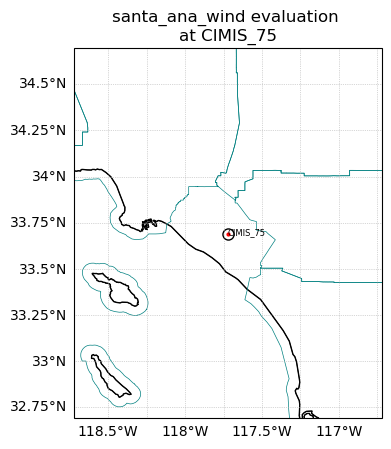

In [10]:
stn_visualize(
    stn_id = eval_stations['era-id'].values[-1],
    stn_list = eval_stations,
    event_to_eval = 'santa_ana_wind'
)

### Step 2: Holistic / qualitative station evaluation
Identify flags set during the entire timeseries for the designated station

In [11]:
# pull station from AWS
# ds = pull_nc_from_aws(eval_stations['era-id'].values[-1]) # from station 
ds = pull_nc_from_aws('CIMIS_45') # manually
ds

Retrieving data for station...


<xarray.Dataset>
Dimensions:               (station: 1, time: 26304)
Coordinates:
  * station               (station) object 'CIMIS_45'
  * time                  (time) datetime64[ns] 1986-01-01T09:00:00 ... 1989-...
Data variables: (12/30)
    tas                   (station, time) float64 ...
    pr                    (station, time) float64 ...
    hurs                  (station, time) float64 ...
    rsds                  (station, time) float64 ...
    sfcWind               (station, time) float64 ...
    sfcWind_dir           (station, time) float64 ...
    ...                    ...
    sfcWind_dir_eraqc     (station, time) float64 ...
    elevation_eraqc       (station, time) float64 ...
    tdps_derived_eraqc    (station, time) int64 ...
    pvp_derived_eraqc     (station, time) float64 ...
    anemometer_height_m   (station, time) float64 ...
    thermometer_height_m  (station, time) float64 ...
Attributes: (12/16)
    title:                 CIMIS quality controlled
    institution:           Eagle Rock Analytics / Cal Adapt
    source:                
    history:               CIMIS_clean.py script run on 02-13-2023, 22:25:54 ...
    comment:               Intermediate data product: may not have been subje...
    license:               
    ...                    ...
    wind_vane_height_m:    2.0
    anemometer_height_m:   2.0
    thermometer_height_m:  1.5
    humidity_height_m:     1.5
    rain_gauge_height_m:   1.0
    raw_files_merged:      3

In [12]:
%%time 
df, MultiIndex, attrs, var_attrs, era_qc_vars = qaqc_ds_to_df(ds)

Filling anemometer_height_m with NaN.
Filling thermometer_height_m with NaN.
CPU times: user 171 ms, sys: 12.9 ms, total: 183 ms
Wall time: 183 ms


In [13]:
# santa ana wind vars: air temp, humidity, wind speed, wind direction
vars_to_check = ['tas', 'hurs', 'sfcWind', 'sfcWind_dir']
vars_to_eval = [var for var in vars_to_check if var in df.columns] # check if variable is not present in the specific station

for var in vars_to_eval:
    known_issue_check(network=df.station.unique()[0].split('_')[0], 
                      var=var, 
                      stn=df.station.unique()[0]) # check if known issues are present first!
    print('Evaluating: {}'.format(var))
    flagged_timeseries_plot(df, var=var)

Checking for known station issues...
Evaluating: tas
Checking for known station issues...
Evaluating: hurs
Checking for known station issues...
Evaluating: sfcWind
Checking for known station issues...
Evaluating: sfcWind_dir


Identify flags set during event for evaluation

In [14]:
subset_df = event_subset(df, event='santa_ana_wind', buffer=14)

Subsetting station record for event duration with 14 day buffer...


In [15]:
# identify flags set for initial pass
for v in vars_to_eval:
    f = flags_during_event(subset_df, var=v, event='santa_ana_wind')

Flags set on tas during santa_ana_wind event: [nan]
Flags set on hurs during santa_ana_wind event: [nan]
Flags set on sfcWind during santa_ana_wind event: [nan]
Flags set on sfcWind_dir during santa_ana_wind event: [nan]


In [17]:
for var in vars_to_eval:
    event_plot(subset_df, var=var, event='santa_ana_wind')

TypeError: event_plot() missing 2 required positional arguments: 'alt_start_date' and 'alt_end_date'

### Optional multi-station run and identification of flags

In [ ]:
eval_stations = subset_eval_stns(
    event_to_eval = 'santa_ana_wind',
    stn_list = train_stns,
    subset = None,
    return_stn_ids = True
)

In [ ]:
stns_to_run = list(eval_stations['era-id'])
multi_stn_check(stns_to_run, 'santa_ana_wind')

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.epsg(3857)})
ax.coastlines()
eval_stations.plot(ax=ax, markersize=8)

# ax.plot(lon, lat, 'ok', markersize=8, transform=ccrs.PlateCarree(), mfc='none')
# ax.plot(x, y, '.r', markersize=4)

---
#### Append local GHCNh library path

In [ ]:
ghcnh_lib_path = "/Users/hector/ERA_work/historical-obs-platform/test_platform/scripts/3_qaqc_data/qaqc_eval_notebooks/GHCNh"
sys.path.append(ghcnh_lib_path)
# from GHCNh.GHCNh_lib import GHCNh  # If GHCNh is within current folder
from GHCNh_lib import GHCNh # If GHCNh is was appended to path

In [ ]:
%%time
ghcnh = GHCNh(stations_local=True)
ghcnh.select_wecc()
id = ghcnh.stations_df['id'].iloc[0]
ghcnh.read_data_from_url(id, save=True)
ghcnh.convert_df_to_gpd()
ghcnh.station_data.head(3)

In [ ]:
lon = ghcnh.station_data.Longitude.mean()
lat = ghcnh.station_data.Latitude.mean()
print("{}, {:.5f}, {:.5f}".format(id, lon, lat))

In [ ]:
fig,ax = plt.subplots(figsize=(9,3))

ghcnh.station_data.plot(ax=ax, x="time", y="temperature")
ghcnh.station_data.plot(ax=ax, x="time", y="dew_point_temperature")
ax.set_title("{}  ({:.3f}, {:.3f})".format(id,lon,lat));

In [ ]:
# initial test for identifying the event: large jumps on windspeed

In [ ]:
return_ghcn_vars(ghcnh.station_data, 'sfcWind').head(3)